In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
# sys.path.append(os.path.abspath("../model_utils"))
sys.path.append(os.path.abspath("../3_classifier"))

import numpy as np
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import itertools
from sklearn.cluster import KMeans

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
classifier_model = torch.load('../3_classifier/1713378970361-resnext29_8_64_sgd_plateau_bs96_lr1.0e-02_wd1.0e-03-best-acc-no-dataaug.pth', map_location=device)
classifier_model.eval();

In [4]:
# classifier_model

In [4]:
import utils_fid as uf


gen_data, gen_paths = uf.get_embedding(classifier_model, '../data/embedding', class_c='BOAFAB_GENERATED', sample_size=np.inf, batch_processing=2)
real_data, real_paths = uf.get_embedding(classifier_model, '../data/embedding', class_c='BOAFAB_REAL', sample_size=1000)

100%|██████████| 1940/1940 [02:54<00:00, 11.14audios/s]
 83%|████████▎ | 999/1.20k [01:49<00:22, 9.10audios/s] 


## FID inicial

In [5]:
fid_score_base = uf.calculate_fid(real_data, gen_data, verbose=True)
fid_score_base


FID (termino 1):  347.19012
FID (termino 2):  167.21909084684813


514.4092153585668

## Seleccion de cantidad de clusters para k-means

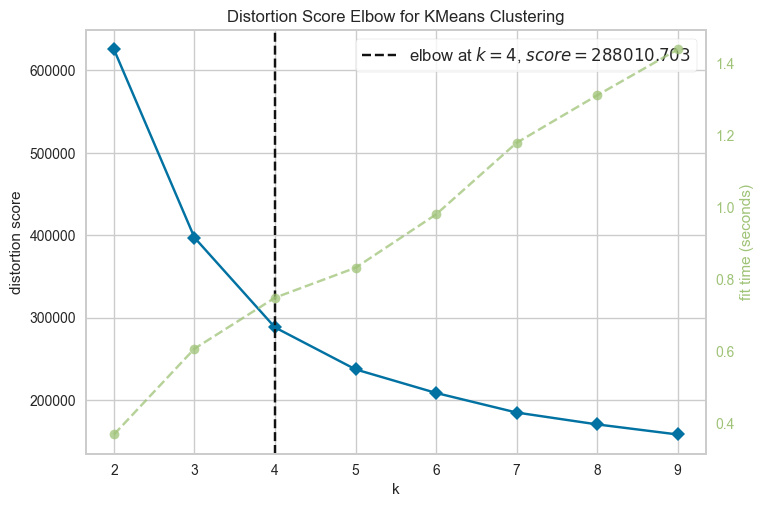

In [18]:
from sklearn import datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.simplefilter("ignore")

# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(gen_data)        # Fit the data to the visualizer
visualizer.show()      
n_clusters = visualizer.elbow_value_

## Clusterizar datos generados

In [6]:
## clusterin generative data
from sklearn.cluster import KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(gen_data)

## seleccion de cluster

In [7]:
import itertools

power_set = list(itertools.chain.from_iterable(itertools.combinations(range(n_clusters), r) for r in range(n_clusters)))
# power_set

In [ ]:
min_value = np.inf
set_to_take = None
for out_set in power_set:
   print(f"Sacando cluster {out_set}")
   _mask = np.ones(len(gen_data), dtype=bool)
   for i in out_set:
      _mask = _mask & (kmeans.labels_ != i)
   fid_score = uf.calculate_fid(real_data, gen_data[_mask], verbose=True)
   if np.abs(fid_score) <= min_value:
      set_to_take = out_set
      min_value = np.abs(fid_score)
   
   print(fid_score)

   print('----------------------------------------------')

In [9]:
set_to_take

(2, 3)

## Numero de clusters de acuerdo al FID.

In [6]:
for k in range(4, 8):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(gen_data)
    min_value = np.inf
    set_to_take = None
    power_set = list(itertools.chain.from_iterable(itertools.combinations(range(k), r) for r in range(k)))
    for out_set in power_set:
        _mask = np.ones(len(gen_data), dtype=bool)
        for i in out_set:
            _mask = _mask & (kmeans.labels_ != i)
        fid_score = uf.calculate_fid(real_data, gen_data[_mask])
        if np.abs(fid_score) <= min_value:
            set_to_take = out_set
            min_value = np.abs(fid_score)

    print(f'Mejor FID para {k} clusters sacando {set_to_take}: {min_value}')

Mejor FID para 4 clusters sacando (2, 3): 119.67693328857422
Mejor FID para 5 clusters sacando (2, 3): 111.78974353764002
Mejor FID para 6 clusters sacando (2, 3): 121.86180822752547
Mejor FID para 7 clusters sacando (2, 3, 6): 139.52905214507155


In [39]:
_mask = np.ones(len(gen_data), dtype=bool)
for i in set_to_take:
    _mask = _mask & (kmeans.labels_ != i)
_mask.sum()

976

In [9]:
data = np.vstack((
    real_data,
    gen_data
))
grouper = ['Real'] * len(real_data) + ['Generated'] * len(gen_data)
scaled_real_data = scale(data)
scaled_real_data = data

dim_new_dimension = 2

pca = PCA(n_components=dim_new_dimension)
pca.fit(scaled_real_data)

data_transformed = pca.transform(scaled_real_data)

c:\Users\snung\miniconda3\envs\myenv\Lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\snung\miniconda3\envs\myenv\Lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


## M

----
Incluir datos de Data Augementation

In [ ]:
aug_data, aug_paths = uf.get_embedding(classifier_model, '../data/embedding', class_c='BOAFAB_DATA_AUG', sample_size=1000)


100%|█████████▉| 999/1.00k [02:50<00:00, 5.85audios/s] 


In [30]:
fid_score = uf.calculate_fid(real_data, aug_data)
fid_score


FID (termino 1):  20.955914
FID (termino 2):  15.269851084116276


36.22576462781745

In [51]:
label_data_gen = kmeans.predict(aug_data)
_mask = (label_data_gen == 0) | (label_data_gen == 2)
print(_mask.sum())
fid_score = uf.calculate_fid(real_data, aug_data[_mask])
fid_score


792


168.92385864257812

In [11]:
data = np.vstack((
    real_data,
    gen_data,
    # aug_data
))
grouper = ['Real'] * len(real_data) + ['Generated'] * len(gen_data)\
    # + ['DATA_AUG'] * len(aug_data)
scaled_real_data = scale(data)

dim_new_dimension = 3

pca = PCA(n_components=dim_new_dimension)
pca.fit(scaled_real_data)

data_transformed = pca.transform(scaled_real_data)

c:\Users\snung\miniconda3\envs\myenv\Lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\snung\miniconda3\envs\myenv\Lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


C:\Users\snung\AppData\Local\Temp\ipykernel_1532\3224259092.py:3: UserWarning:

The palette list has more values (3) than needed (2), which may not be intended.



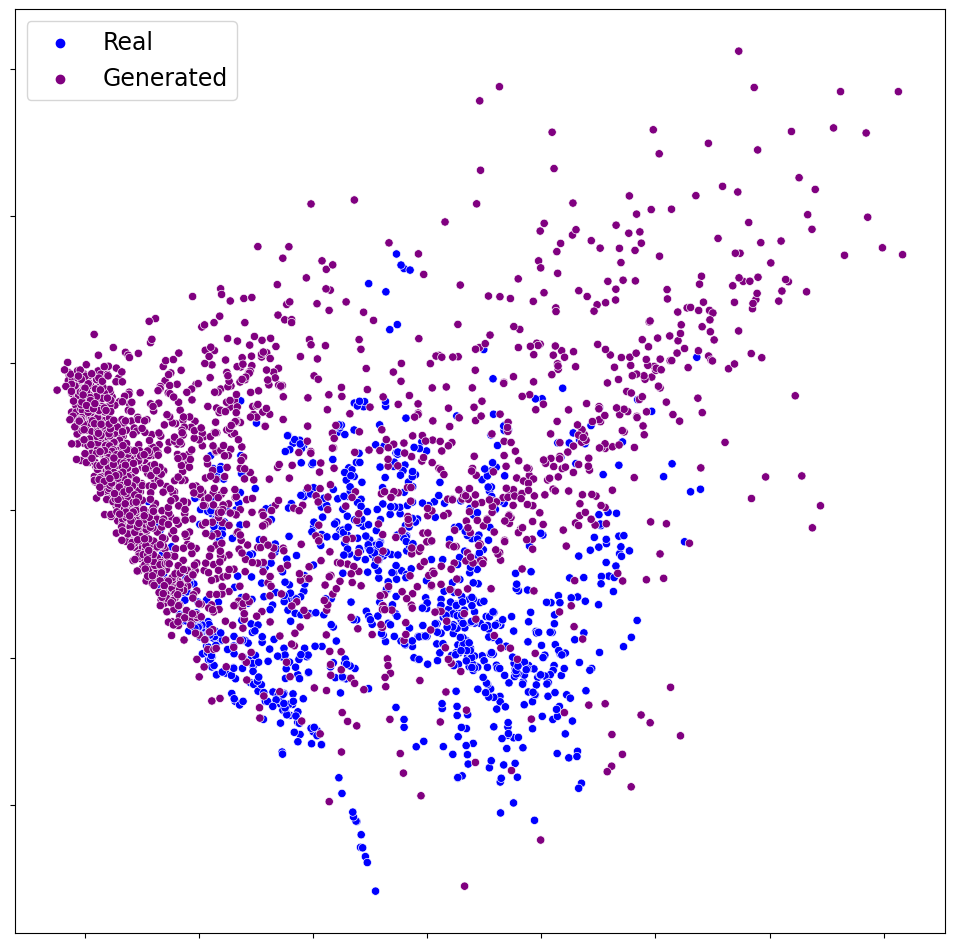

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.scatterplot(
    x=data_transformed[:, 0],
    y=data_transformed[:, 1],
    hue=grouper,
    palette=['blue', 'purple', 'red'],
    ax=ax
)
# x1, x2, y1, y2 = -1, 7, -2, 1  # subregion of the original image
# axins = ax.inset_axes(
#     [0.5, 0.5, 0.47, 0.47],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

# # Add labels from the 'labels' column
# for i, (x, y) in enumerate(data_transformed):
#     plt.text(x, y, i, fontsize=10)



# sns.scatterplot(
#     x=data_transformed[:, 0],
#     y=data_transformed[:, 1],
#     hue=grouper,
#     palette=['blue', 'purple'],
#     ax=axins
# )
# ax.indicate_inset_zoom(axins,  edgecolor="black", alpha=1,lw=0.7)
# axins.get_legend().set_visible(False)

axins.set_xticks([])
axins.set_yticks([])
ax.legend(fontsize=17)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

------

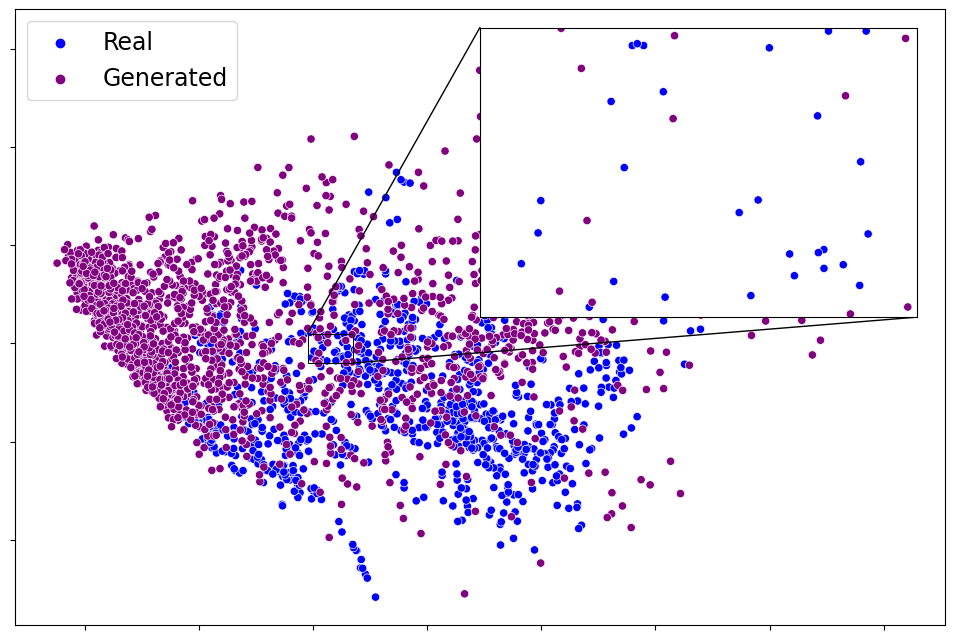

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(
    x=data_transformed[:, 0],
    y=data_transformed[:, 1],
    hue=grouper,
    palette=['blue', 'purple'],
    ax=ax
)
x1, x2, y1, y2 = -1, 7, -2, 1  # subregion of the original image
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

# # Add labels from the 'labels' column
# for i, (x, y) in enumerate(data_transformed):
#     plt.text(x, y, i, fontsize=10)



sns.scatterplot(
    x=data_transformed[:, 0],
    y=data_transformed[:, 1],
    hue=grouper,
    palette=['blue', 'purple'],
    ax=axins
)
ax.indicate_inset_zoom(axins,  edgecolor="black", alpha=1,lw=0.7)
axins.get_legend().set_visible(False)

axins.set_xticks([])
axins.set_yticks([])
ax.legend(fontsize=17)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

In [19]:
import pandas as pd
import plotly.express as px

df_audios = pd.DataFrame(data_transformed, columns=['x', 'y'])
df_audios['num'] = df_audios.index
df_audios['type'] = grouper

fig = px.scatter(df_audios, x="x", y="y", color="type", hover_name='num', color_discrete_sequence=['blue', 'purple', 'red'])

fig.show()


# G

In [44]:
data_transformed.shape

(2000, 3)

In [53]:
real_cluster = kmeans.predict(real_data)
_mask = np.ones(len(real_data), dtype=bool)
for i in set_to_take:
    _mask = _mask & (real_cluster != i)
_mask.sum()

951

In [12]:
set_to_take

(2, 3)

In [10]:
import pandas as pd
import plotly.express as px

temp_cant = data_transformed.shape[1]
df_audios = pd.DataFrame(data_transformed, columns=['x', 'y', 'z'][:temp_cant])
df_audios['num'] = df_audios.index
df_audios['type'] = grouper
df_audios['group'] = grouper
df_audios.loc[df_audios['type'] ==  'Generated', 'group'] = [f'$S_{i}$'for i in kmeans.labels_]
# df_audios.loc[df_audios['type'] ==  'Real', 'group'] = [f'Real_{i}'for i in real_cluster]

In [11]:
df_audios['paths'] =  real_paths + gen_paths

In [12]:
df_audios.loc[df_audios['paths'].str.contains('273')]

,x,y,num,type,group,paths
273,-5.487460,-9.944657,273,Real,Real,../data/embedding\BOAFAB_REAL\273.wav
1273,34.659882,-0.483159,1273,Generated,$S_1$,../data/embedding\BOAFAB_GENERATED\273.wav
2273,-11.879863,-3.324515,2273,Generated,$S_0$,../data/embedding\BOAFAB_GENERATED\1273.wav


In [14]:
fig = px.scatter(df_audios, x="x", y="y", color="type", hover_name='num')

fig.show()

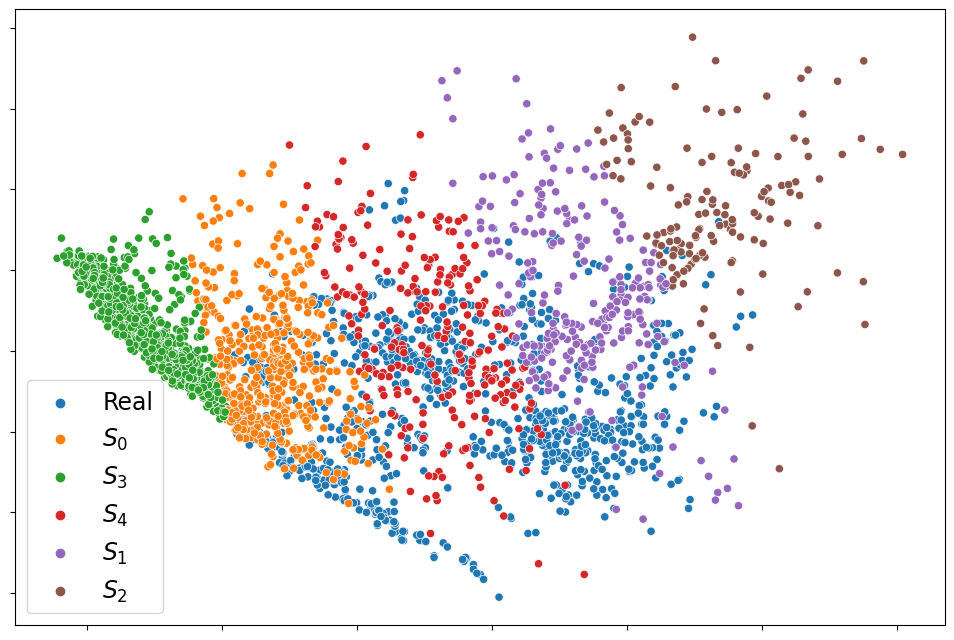

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(data=df_audios, x="x", y="y", hue="group", ax=ax)
# x1, x2, y1, y2 = -1, 7, -2, 1  # subregion of the original image
# axins = ax.inset_axes(
#     [0.5, 0.5, 0.47, 0.47],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

# # # Add labels from the 'labels' column
# # for i, (x, y) in enumerate(data_transformed):
# #     plt.text(x, y, i, fontsize=10)



# sns.scatterplot(
#     x=data_transformed[:, 0],
#     y=data_transformed[:, 1],
#     hue=grouper,
#     palette=['blue', 'purple'],
#     ax=axins
# )
# ax.indicate_inset_zoom(axins,  edgecolor="black", alpha=1,lw=0.7)
# axins.get_legend().set_visible(False)

axins.set_xticks([])
axins.set_yticks([])
ax.legend(fontsize=17)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()



In [16]:
import librosa
paths = real_paths + gen_paths
def load_audio(path, verbose=False):
    audio, sr = librosa.load(path, sr=16_000)

    return audio, sr

In [17]:
from IPython.display import Audio

load_path = paths[2280]
print(load_path)
audio, sr = load_audio(load_path)

Audio(data=audio, rate=16_000)

../data/embedding\BOAFAB_GENERATED\1280.wav


# Save database

In [65]:
to_save = {'Real': [], 'Generado': []}
banned_grups = [f'Generated_{i}' for i in set_to_take]\
      + [f'Real_{i}' for i in set_to_take] + ['Generated_0', "Real_0"]
for i in range(len(paths)):
    root = paths[i]
    row = df_audios.iloc[i]
    real = True if row.type == 'Real' else False
    if row.group in banned_grups :
        continue
    
    audio, sr = load_audio(root)
    
    dict_audio = {
        'root': root,
        'real': real,
        'audio': audio,
        'sr': 16_000,
        'mark': []
    }
    if real:
        to_save["Real"].append(dict_audio)
    else:
        to_save["Generado"].append(dict_audio)

In [35]:
# to_save['Generado']

In [67]:
import pickle

with open('./audios_to_human_test.pkl', 'wb') as f:
    pickle.dump(to_save, f)

In [38]:
a = list(range(10))

In [42]:
a.pop(0)

3

In [45]:
import random
random.uniform(0, 1)

0.22053146036169435